# Imports

In [14]:
import numpy as np
import tensorflow as tf
import json

from tensorflow.keras import Model
from tensorflow.keras.layers import Layer, Input, Dense, Activation, Add, Concatenate, Reshape
from tensorflow.keras.callbacks import Callback, CSVLogger
from tensorflow.keras.regularizers import L2

tf.keras.backend.set_floatx('float64')

# Defining Normalizator, Denormalizator and NullNormalizator

In [15]:
class BaseNormalizator(Layer):
    """
    Коэффициенты записаны в виде весов, чтобы они попадали в файл весов модели.
    """
    def __init__(self, loc, scl, **kwargs):
        super().__init__(**kwargs)
        self.loc = loc
        self.scl = scl
        self.trainable = False

    def build(self, input_shape):
        n_loc = np.array(self.loc)
        n_scl = np.array(self.scl)
        self.const_loc = self.add_weight(
            name="loc",
            shape=n_loc.shape,
            initializer=tf.constant_initializer(n_loc),
            trainable=False)
        self.const_scl = self.add_weight(
            name="scl",
            shape=n_scl.shape,
            initializer=tf.constant_initializer(n_scl),
            trainable=False)
        self.built = True

    def get_config(self):
        config = {'loc': self.loc, 'scl': self.scl}
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))


class Normalizator(BaseNormalizator):
    def call(self, ten):
        return (ten - self.const_loc) / self.const_scl


class Denormalizator(BaseNormalizator):
    def call(self, ten):
        return self.const_scl * ten + self.const_loc


class NullNormalizator:
    """
    Пустой класс, затычка вместо нормализации
    """
    def __call__(self, ten):
        return ten

## Additional: reading JSON

In [16]:
def read_json(json_filepath):
    with open(json_filepath, 'r') as json_file:
        content = json_file.read()

    if len(content) == 0:
        return dict()

    return json.loads(content)

# Describing base neural network training class, that will use system hyper-parameters, defining how network should be trained and how to calculate weight coefficients.

In [17]:
class AnnNeuronBaseSplit:
    def __init__(self, var_names, prm_file, batch_size, regul, callbacks, optimizer='adam'):
        self.var_names = var_names

        self.params = read_json(prm_file)
        
        self.dim_p = self.params['dim_p']
        self.dim_u = self.params['dim_u']
        self.stab_u = tf.constant(self.params['stab_u'], name='stab_u', dtype=tf.float64)
        self.stab_d = tf.constant(self.params['stab_d'], name='stab_d', dtype=tf.float64)

        # Эта функция должна быть определена в дочернем класса
        self.model = self.model_builder(self.var_names, self.params, regul)

        self.model.compile(optimizer=optimizer,
                           loss='mse',
                           metrics=['mae'])
        self.callbacks = callbacks
        self.batch_size = batch_size
        self.initial_epoch=0
        

    def fit(self, epochs, x_train, y_train, x_valid, y_valid, verbose=0):
        out = self.model.fit(x=x_train,
                             y=y_train,
                             validation_data=[x_valid, y_valid],
                             initial_epoch=self.initial_epoch,
                             epochs=self.initial_epoch + epochs,
                             batch_size=self.batch_size,
                             verbose=verbose,
                             shuffle=True,
                             callbacks=self.callbacks)

        self.initial_epoch += epochs
        
        return out

    @staticmethod
    def iter_model(model_dir, prm_file, it_max, it_step, normalize=True):
        prm = read_json(prm_file)
        
        model = tf.keras.models.load_model(model_dir)

        inp_p = Input(shape=(prm['dim_p'],))
        inp_u = Input(shape=(prm['dim_u'],))

        if normalize:
            norm_p = Normalizator(prm['loc_p'], prm['scl_p'])
            norm_u = Normalizator(prm['loc_u'], prm['scl_u'])
            denorm_u = Denormalizator(prm['loc_u'], prm['scl_u'])
        else:
            norm_p = NullNormalizator()
            norm_u = NullNormalizator()
            denorm_u = NullNormalizator()

        pp = norm_p(inp_p)
        uu = norm_u(inp_u)

        out = [uu]
        t_end = 0
        for it in range(0, it_max, it_step):
            for k in range(it, it + it_step):
                uu = model([pp, uu], training=False)
            out.append(uu)
        out = denorm_u(tf.transpose(tf.stack(out), perm=(1,0,2)))
        
        model_it = Model(inputs=[inp_p, inp_u], outputs=out)
        model_it.time_step = prm['time_step'] * it_step
        model_it.t_end = prm['time_step'] * it_max
        model_it.compile()

        return model_it

# Generating train data

In [18]:
from dataclasses import dataclass

@dataclass
class NeurPrm:
    tau: float = 0.02
    g_Ca: float = 3.6
    V_Ca: float = 25.0
    Th_m: float = 12.0
    V_m: float = -20.0

    tau_S: float = 35.0
    g_K: float = 10.0
    V_K: float = -75.0
    Th_n: float = 5.6
    V_n: float = -16.0

    sig: float = 0.93
    g_S: float = 4.0
    Th_S: float = 10.0

    V_S: float = -35.0

    g_cV: float = 0.15  # Параметр связи

    # Модифицированная система
    modif: bool = False

    g_K2: float = 0.2
    Th_p: float = 1.0
    V_p: float = -47.0

In [19]:
def omg_inf(V, V_omg, Th_omg):
    return 1.0 / (1.0 + np.exp((V_omg - V) / Th_omg))


def m_inf(V, p):
    return omg_inf(V, p.V_m, p.Th_m)


def n_inf(V, p):
    return omg_inf(V, p.V_n, p.Th_n)


def S_inf(V, p):
    return omg_inf(V, p.V_S, p.Th_S)


def I_Ca(V, p):
    return p.g_Ca * m_inf(V, p) * (V - p.V_Ca)


def I_K(V, n, p):
    return p.g_K * n * (V - p.V_K)


def I_S(V, S, p):
    return p.g_S * S * (V - p.V_K)


def p_inf(V, p):
    x = (V - p.V_p) / p.Th_p
    ex = np.exp(x if x < 0 else -x)
    return ex / (ex * ex + 1.0)


def I_K2(V, p):
    return p.g_K2 * p_inf(V, p) * (V - p.V_K)


def sherman(t, uu, p):
    V, n, S = uu
    V_dot = - I_Ca(V, p) - I_K(V, n, p) - I_S(V, S, p)
    if p.modif:
        V_dot -= I_K2(V, p)
    V_dot /= p.tau

    n_dot = p.sig * (n_inf(V, p) - n) / p.tau
    S_dot = (S_inf(V, p) - S) / p.tau_S
    
    return [V_dot, n_dot, S_dot]

In [20]:
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

rng = np.random.default_rng()

In [21]:
t0, dt = 100, 25

method = 'Radau'
p = NeurPrm(modif=True, V_p=-49.5, g_K2=0.12, V_S=-36)

u0 = rng.uniform(size=3)

t_eval = np.arange(t0, t0 + dt, 0.005)
sol = solve_ivp(sherman, [0, t_eval[-1]], u0, args=[p], method=method, t_eval=t_eval)

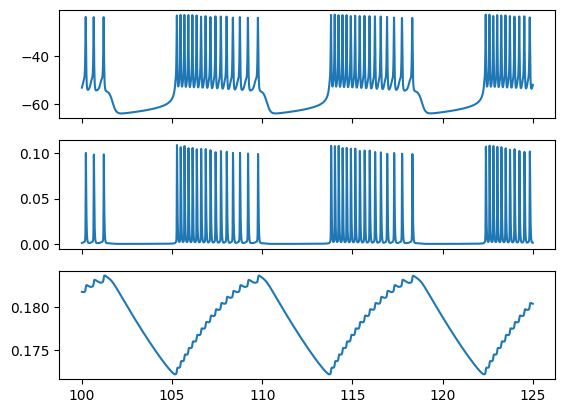

In [22]:
fix, axs = plt.subplots(3, 1, sharex=True)

for i in range(3):
    axs[i].plot(sol.t, sol.y[i, :])

# Inherited class, implementation of `AnnNeuronBaseSplit`.

In [23]:
class ShermanSplit(AnnNeuronBaseSplit):
    def __init__(self, var_names, prm_file, batch_size, regul, callbacks, optimizer='adam'):
        super().__init__(var_names, prm_file, batch_size, regul, callbacks, optimizer)

    """
    Для каждой переменной своя модель. Только один скрытый слой
    """
    def model_builder(self, var_names, params, regul):
        """
        params['actfun_prm']
        params['actfun_var1']
        params['hidsize_var1']
        """

        dim_p = params['dim_p']
        dim_u = params['dim_u']
        models = [self._model1(nn, dim_p, dim_u,
                               params[f'actfun_prm_{var_names[nn]}'],
                               params[f'actfun_var1_{var_names[nn]}'],
                               params[f'hidsize_var1_{var_names[nn]}'],
                               regul,
                               var_names[nn]) for nn in range(dim_u)]

        inp_p = Input(shape=(dim_p,), name='inp_p')
        inp_u = Input(shape=(dim_u,), name='inp_u')

        out_u = tf.transpose(tf.stack([m([inp_p, inp_u]) for m in models]))

        model = Model(inputs=[inp_p, inp_u], outputs=out_u,
                      name='sherman_' + ''.join(var_names))

        return model

    def _model1(self, nvar, dim_p, dim_u,
                actfun_prm, actfun_var1, hidsize_var1, regul, name):

        inp_p = Input(shape=(dim_p,), name='inp_p')
        inp_u = Input(shape=(dim_u,), name='inp_u')

        if isinstance(actfun_prm, str) and actfun_prm.lower() == 'none':
            actfun_prm = None

        dense_prm = Dense(hidsize_var1,
                          kernel_regularizer=(L2(regul) if regul is not None else None),
                          activation=actfun_prm,
                          use_bias=(actfun_prm is not None),
                          name='dense_prm')
        dense_hid = Dense(hidsize_var1,
                          kernel_regularizer=(L2(regul) if regul is not None else None),
                          name='dense_hid')
        activat_hid = Activation(actfun_var1, name='activat_hid')
        add = Add(name='add')
        con = Concatenate(name='con')

        dense_out = Dense(1,
                          kernel_regularizer=(L2(regul) if regul is not None else None),
                          name='dense_out')

        u0 = inp_u[:, nvar:nvar+1]
        inx = list(range(dim_u))
        del inx[nvar]
        pu = tf.gather(inp_u, inx, axis=1)

        px = dense_prm(con([inp_p, pu]))
        ux = dense_hid(u0)

        ux = add([ux, px])
        ux = activat_hid(ux)

        # squeeze удаляет лишнюю размерность (None, 1) -> (None,)
        u1 = tf.squeeze(u0 * self.stab_u + dense_out(ux) * self.stab_d, axis=[-1])

        model = Model(inputs=[inp_p, inp_u], outputs=u1, name=name)
        
        return model

# Building model and creating `TrainDataGenerator`.

In [24]:
# ShermanSplit: var_names, params, batch_size, regul, callbacks, optimizer='adam'
logs_filepath = 'messages.csv'
params_filepath = 'params.json'
var_names = ['V', 'n', 'S']
batch_size = 1000
regul = None
callbacks = [CSVLogger(logs_filepath, separator=';', append=True)]
optimizer = 'adam'

model = ShermanSplit(var_names=var_names,
                     prm_file=params_filepath,
                     batch_size=batch_size,
                     regul=regul,
                     callbacks=callbacks,
                     optimizer=optimizer)

## Generating Train data. `x_train`, `y_train`, `x_test`, `y_test` are initialized from the solvation of differential equations system, that was emulated in the section above.

In [36]:
class TrainDataGenerator:
    def __init__(self, params_filepath, t0=100, dt=25, deqs_method='Radau'):
        self.params = read_json(params_filepath)
        self.t0 = t0
        self.dt = dt
        self.rng = np.random.default_rng()
        self.u0 = self.rng.uniform(size=3)
        self.S = self.params['trajectory_points_list_size']
        self.C = self.params['chunks_count']
        self.deqs_method = deqs_method

    def generate_dataset(self):
        dataset = []
        for i in range(1, self.C + 1):
            row = self.build_dataset_row(i, self.u0)
            dataset.append(row)

        return dataset

    def build_dataset_row(self, i, uu):
        t = self.t0 + i * self.dt
        V_S = self.rng.uniform(low=-40.0, high=-30.0)
        p = NeurPrm(modif=True, V_p=-49.5, g_K2=0.12, V_S=V_S)
        t_eval = np.arange(self.t0, self.t0 + (i + 1) * self.dt, (i + 1) * self.dt / self.S) 
        sol = solve_ivp(sherman, [0, t_eval[-1]], uu, args=[p], method=self.deqs_method, t_eval=t_eval)
        
        vec_u = self.build_trajectory_points(sol.y)
        chunk = self.build_chunk(vec_u, V_S)

        return chunk

    def build_trajectory_points(self, ivp_solvation):
        Vs, ns, Ss = ivp_solvation[0, :], ivp_solvation[1, :], ivp_solvation[2, :]
        vec_u = list(zip(Vs, ns, Ss))
        
        return vec_u

    def build_chunk(self, vec_u, p):
        chunk = []
        for i in range(len(vec_u) - 1):
            chunk.append((p, vec_u[i], vec_u[i + 1]))

        return chunk

    def save_train_data_as_file(self, dataset, train_data_filepath='train_data.json'):
        with open(train_data_filepath, 'w') as out_json:
            out_json.write(json.dumps(dataset))

    def read_train_data_from_file(self, train_data_filepath='train_data.json'):
        with open(train_data_filepath, 'r') as train_file:
            train_data = json.loads(train_file.read())

        return train_data

In [ ]:
generator = TrainDataGenerator(params_filepath=params_filepath, deqs_method='Radau')
dataset = generator.generate_dataset()

In [ ]:
train_data_filepath = 'train_data.json'

generator.save_train_data_as_file(dataset, train_data_filepath=train_data_filepath)

# Training

In [ ]:
train_data = generator.read_train_data_from_file()